In [8]:
import pickle
from copy import deepcopy
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from catboost import CatBoostClassifier
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# from tqdm import tqdm
sns.set()
shap.initjs()
warnings.filterwarnings('ignore')

In [9]:
RANDOM_STATE = 42
RANDOM_SEED = RANDOM_STATE

In [72]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

In [10]:
df = pd.read_csv('../data/clean/train.csv')

In [11]:
df.head()

,checking_status,duration_months,credit_history,purpose,credit_amount,savings_status,employment_years,installment_commitment,personal_status,other_parties,...,property_magnitude,age_years,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,target
0,no checking,18,critical/other existing credit,radio/tv,1800,<100,1<=X<4,4,male single,none,...,car,24,none,own,2,skilled,1,none,yes,0
1,<0,24,existing paid,radio/tv,2439,<100,<1,4,female div/dep/mar,none,...,real estate,35,none,own,1,skilled,1,yes,yes,1
2,no checking,36,no credits/all paid,repairs,2613,<100,1<=X<4,4,male single,none,...,car,27,none,own,2,skilled,1,none,yes,0
3,no checking,15,existing paid,education,4623,100<=X<500,1<=X<4,3,male single,none,...,life insurance,40,none,own,1,high qualif/self emp/mgmt,1,yes,yes,1
4,<0,21,existing paid,furniture/equipment,3599,<100,4<=X<7,1,female div/dep/mar,none,...,car,26,none,rent,1,unskilled resident,1,none,yes,0


In [12]:
X = df.drop('target', axis=1).columns
y = ['target']

In [13]:
cols2drop = []
target = ['target']
num_features = [c for c in df.columns if c not in target and pd.api.types.is_numeric_dtype(df[c])]
cat_features = [c for c in df.columns if c not in target and c not in num_features]
assert len(target) + len(num_features) + len(cat_features) + len(cols2drop) == len(df.columns)

In [14]:
train, test = train_test_split(df, test_size=0.20, random_state=RANDOM_STATE, stratify=df[y])
print(f'Размер обучающей выборки {train.shape}, это составляет {len(train)/len(df):.2%} данных')
print(f'Размер тестовой выборки {test.shape}, это составляет {len(test)/len(df):.2%} данных')

Размер обучающей выборки (640, 21), это составляет 80.00% данных
Размер тестовой выборки (160, 21), это составляет 20.00% данных


In [15]:
kfold = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

### Создание функций

In [45]:
def rs(model, grid_params, n_iter, x_train, y_train, verbose=0, random_state=RANDOM_STATE):
    """Hyperparameters tuning with GridSearchCV returns roc_auc CV score"""
    print("Performing grid search...")
    print("Hyperparameters to be evaluated:")
    pprint(grid_params)
    print()

    clf_rnd_gs = RandomizedSearchCV(
        model,
        grid_params,
        random_state=random_state,
        n_iter=n_iter,
        cv=5,
        verbose=verbose,
        n_jobs=-2,
        scoring="roc_auc",
    )

    clf_rnd_gs.fit(x_train, y_train.values.ravel())

    print("Best parameters:")
    for elem in sorted(clf_rnd_gs.best_params_):
        print(f"{elem}: {clf_rnd_gs.best_params_.get(elem)}")

    return (clf_rnd_gs.best_estimator_, clf_rnd_gs)

In [60]:
def plot_cm_rocauc(
    actual_classes,
    predicted_classes,
    predicted_proba,
    sorted_labels=["Good", "Bad"]):
    """Ploting ROC curve and confusion matrix using predictions based on CV"""

    matrix = confusion_matrix(actual_classes, predicted_classes)
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        matrix,
        annot=True,
        xticklabels=sorted_labels,
        yticklabels=sorted_labels,
        cmap="gnuplot",
        fmt="g",
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    probabilities_one = predicted_proba[:, 1]

    sns.set(rc={"figure.figsize": (9, 6)})

    fpr, tpr, thresholds = roc_curve(actual_classes, probabilities_one)
    plt.figure()

    plt.plot(fpr, tpr)

    plt.plot([0, 1], [0, 1], linestyle="--")

    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.title("ROC")

    plt.show()

    rocauc = roc_auc_score(actual_classes, probabilities_one)
    accuracy = accuracy_score(actual_classes, predicted_classes)
    precision = precision_score(actual_classes, predicted_classes)
    recall = recall_score(actual_classes, predicted_classes)
    f1 = f1_score(actual_classes, predicted_classes)

    print("Train data KFold CV:")
    print(f"ROC-AUC {rocauc:.3f}")

    print(classification_report(actual_classes, predicted_classes))

    return rocauc, accuracy, precision, recall, f1


In [18]:

def cross_val_predict(model, kfold, X, y):
    """Predicting classes using CV(KFold)"""

    model_ = deepcopy(model)

    no_classes = len(np.unique(y))

    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes])

    for train_ndx, test_ndx in kfold.split(X):
        train_X, train_y, test_X, test_y = (
            X.iloc[train_ndx],
            y.iloc[train_ndx],
            X.iloc[test_ndx],
            y.iloc[test_ndx],
        )

        actual_classes = np.append(actual_classes, test_y)

        model_.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))

        try:
            predicted_proba = np.append(
                predicted_proba, model_.predict_proba(test_X), axis=0
            )
        except:
            predicted_proba = np.append(
                predicted_proba,
                np.zeros((len(test_X), no_classes), dtype=float),
                axis=0,
            )

    rocauc, accuracy, precision, recall, f1 = plot_cm_rocauc(
        actual_classes,
        predicted_classes,
        predicted_proba
    )

    return (
        rocauc,
        accuracy,
        precision,
        recall,
        f1,
        predicted_proba
    )

In [19]:
def save_results(name):
    '''Accumulating training results'''

    global metrics

    results.loc[name] = [*metrics[:-1]]

    return

In [20]:
results = pd.DataFrame({'ROC-AUC': [],
                        'Accuracy': [],
                        'Precision': [],
                        'Recall': [],
                        'F1_score' : []})

## LogReg

In [21]:
num_pipeline = Pipeline(steps=[
    ('scale', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

pre_processor = ColumnTransformer(transformers=[
    ('number', num_pipeline, num_features),
    ('category', cat_pipeline, cat_features)
])

lr_pipeline = Pipeline(steps=[
    ('preprocess', pre_processor),
    ('classify', LogisticRegression(random_state=RANDOM_STATE))
])

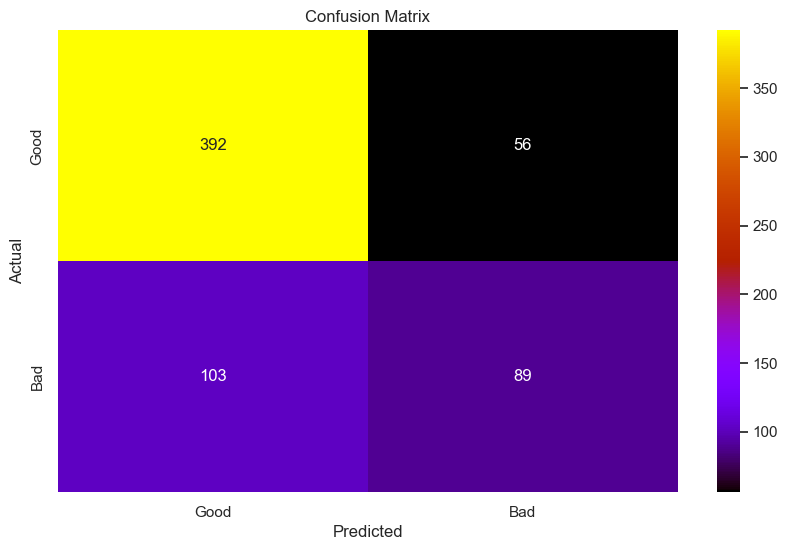

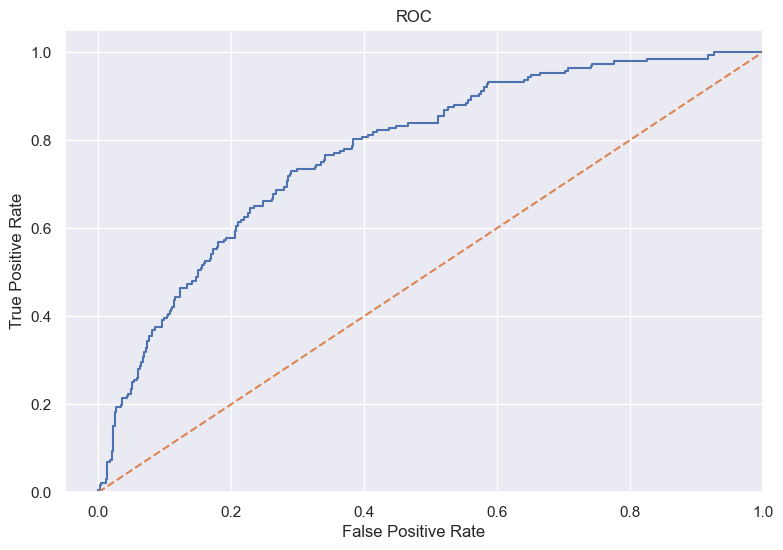

Metrics for train data, using KFold CV:
ROC-AUC   0.776
Accuracy  0.752
Precision 0.614
Recall    0.464
F1_score  0.528
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       448
           1       0.61      0.46      0.53       192

    accuracy                           0.75       640
   macro avg       0.70      0.67      0.68       640
weighted avg       0.74      0.75      0.74       640



In [23]:
# Baseline
metrics = cross_val_predict(lr_pipeline, kfold, train[X], train[y]);

In [24]:
save_results('Baseline_LogReg')

In [25]:
grid_params_lr = {
    'classify__C': np.logspace(-4, 4, 20),
    'classify__class_weight': ['balanced', None],
    'classify__max_iter': range(500, 5001, 500),
    'classify__penalty': ['l2', 'l1', 'elasticnet'],
    #'classify__solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
}

n_iter = 500

best_lr_model, lr_rs = rs(lr_pipeline, grid_params_lr, n_iter, train[X], train[y])

Performing grid search...
Hyperparameters to be evaluated:
{'classify__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
 'classify__class_weight': ['balanced', None],
 'classify__max_iter': range(500, 5001, 500),
 'classify__penalty': ['l2', 'l1', 'elasticnet']}

Best parameters:
classify__C: 0.08858667904100823
classify__class_weight: balanced
classify__max_iter: 1000
classify__penalty: l2


In [27]:
with open('../models/Logistic_regression.pkl', 'wb') as file:
    pickle.dump(best_lr_model, file)

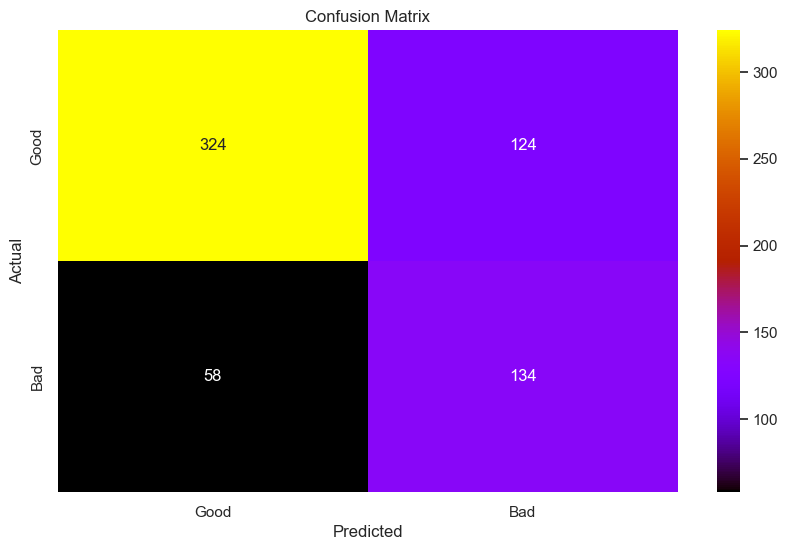

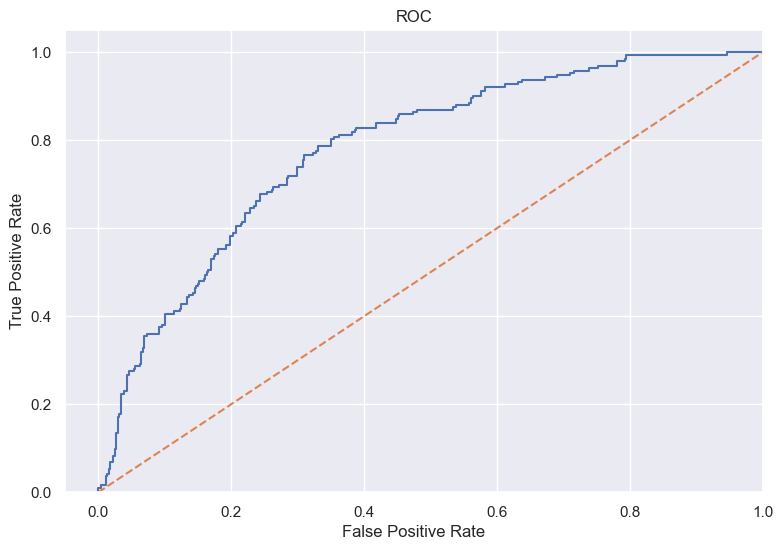

Metrics for train data, using KFold CV:
ROC-AUC   0.780
Accuracy  0.716
Precision 0.519
Recall    0.698
F1_score  0.596
              precision    recall  f1-score   support

           0       0.85      0.72      0.78       448
           1       0.52      0.70      0.60       192

    accuracy                           0.72       640
   macro avg       0.68      0.71      0.69       640
weighted avg       0.75      0.72      0.73       640



In [26]:
metrics = cross_val_predict(best_lr_model, kfold, train[X], train[y]);

In [28]:
save_results('Logistic_regression')

## RF

In [29]:
pre_processor_rf = ColumnTransformer(transformers=[
    ('category', cat_pipeline, cat_features)
])

rf_pipeline = Pipeline(steps=[
    ('preprocess', pre_processor_rf),
    ('classify', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

grid_params_rf = {
    'classify__n_estimators': range(50, 1000, 25),
    'classify__max_depth': range(1, 11),
    'classify__min_samples_leaf': [5, 10, 15, 25, 50, 60, 70, 80, 90, 100],
    'classify__criterion': ['entropy', 'gini'],
    'classify__max_features': [None, 0.75, 0.5, 0.25, 'sqrt', 'log2']
}

n_iter = 500

best_rf_model, rf_rs = rs(rf_pipeline, grid_params_rf, n_iter, train[X], train[y])

Performing grid search...
Hyperparameters to be evaluated:
{'classify__criterion': ['entropy', 'gini'],
 'classify__max_depth': range(1, 11),
 'classify__max_features': [None, 0.75, 0.5, 0.25, 'sqrt', 'log2'],
 'classify__min_samples_leaf': [5, 10, 15, 25, 50, 60, 70, 80, 90, 100],
 'classify__n_estimators': range(50, 1000, 25)}

Best parameters:
classify__criterion: entropy
classify__max_depth: 3
classify__max_features: sqrt
classify__min_samples_leaf: 10
classify__n_estimators: 325


In [30]:
with open('../models/Random_forest.pkl', 'wb') as file:
    pickle.dump(best_rf_model, file)

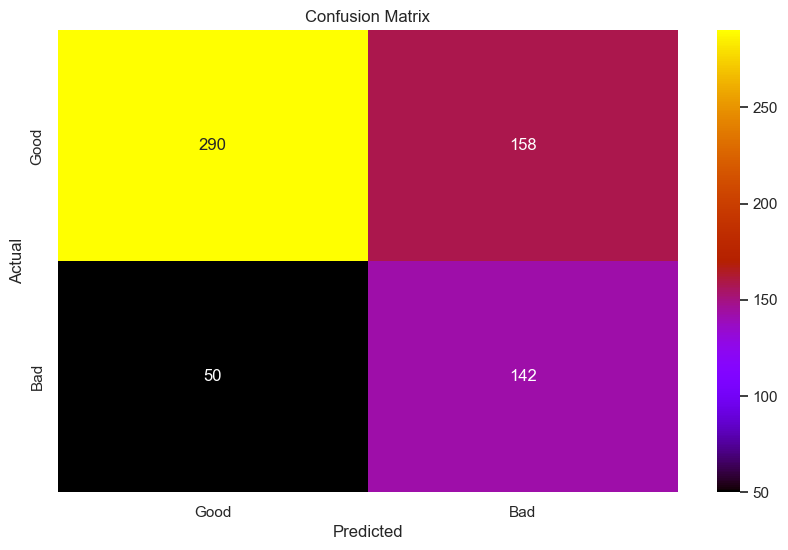

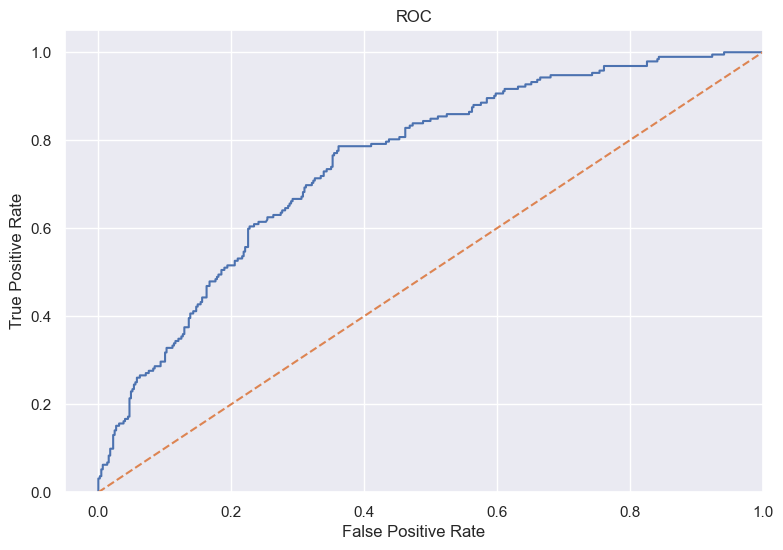

Metrics for train data, using KFold CV:
ROC-AUC   0.751
Accuracy  0.675
Precision 0.473
Recall    0.740
F1_score  0.577
              precision    recall  f1-score   support

           0       0.85      0.65      0.74       448
           1       0.47      0.74      0.58       192

    accuracy                           0.68       640
   macro avg       0.66      0.69      0.66       640
weighted avg       0.74      0.68      0.69       640



In [31]:
metrics = cross_val_predict(best_rf_model, kfold, train[X], train[y]);

In [32]:
save_results('Random_forest')

## CB


In [52]:
params = {
    'cat_features': cat_features,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'auto_class_weights': 'Balanced',
    'random_seed': RANDOM_SEED,
    'verbose': 0
}

In [66]:
grid_params_cb = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2],
    'depth': [2, 4, 6, 8, 10, 12],
    'l2_leaf_reg': np.linspace(1, 30, 10, dtype=int),
    'colsample_bylevel': [x / 100 for x in range(10, 100, 15)] + [None],
    'subsample': [x / 100 for x in range(10, 100, 15)] + [None]
    #'n_estimators': range(100, 1001, 100)
}

n_iter = 500

best_cb_model, cb_rs = rs(CatBoostClassifier(**params), grid_params_cb, n_iter, train[X], train[y])

Performing grid search...
Hyperparameters to be evaluated:
{'colsample_bylevel': [0.1, 0.25, 0.4, 0.55, 0.7, 0.85, None],
 'depth': [2, 4, 6, 8, 10, 12],
 'l2_leaf_reg': array([ 1,  4,  7, 10, 13, 17, 20, 23, 26, 30]),
 'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2],
 'subsample': [0.1, 0.25, 0.4, 0.55, 0.7, 0.85, None]}

Best parameters:
colsample_bylevel: 0.7
depth: 10
l2_leaf_reg: 30
learning_rate: 0.2
subsample: 0.7


In [67]:
with open('../models/Catboost.pkl', 'wb') as file:
    pickle.dump(best_cb_model, file)

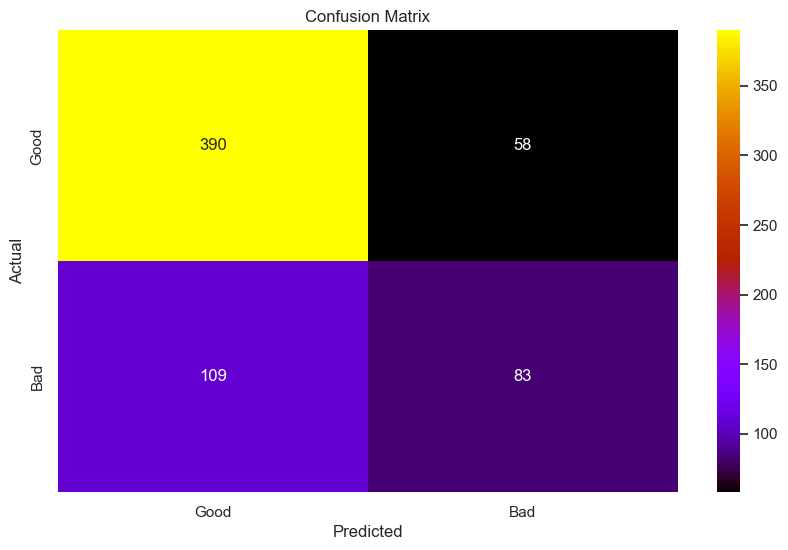

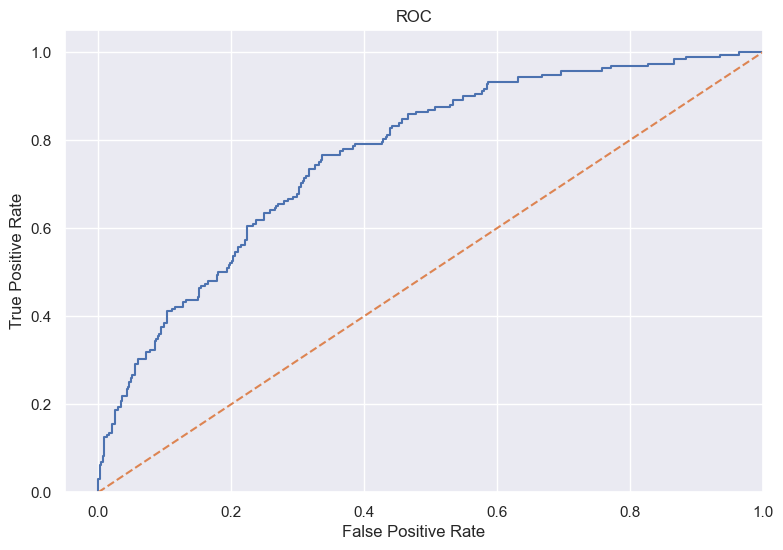

Train data KFold CV:
ROC-AUC 0.768
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       448
           1       0.59      0.43      0.50       192

    accuracy                           0.74       640
   macro avg       0.69      0.65      0.66       640
weighted avg       0.72      0.74      0.73       640



In [68]:
metrics = cross_val_predict(best_cb_model, kfold, train[X], train[y])

In [69]:
save_results('Catboost')

In [70]:
results

,ROC-AUC,Accuracy,Precision,Recall,F1_score
Baseline_LogReg,0.775995,0.751563,0.613793,0.463542,0.528190
Logistic_regression,0.779762,0.715625,0.519380,0.697917,0.595556
Random_forest,0.751006,0.675000,0.473333,0.739583,0.577236
Catboost,0.767566,0.739062,0.588652,0.432292,0.498498
